# 02__filter_data

in this notebook, i perform several QC checks of the screen data, and filter the screen data to a set of robustly captured and reliable sgRNAs.

figures in this notebook:
- Fig S5B: 2D density plot showing undifferentiated counts vs. day zero counts for scrambled sgRNAs
- Fig 3C: 2D density plot showing undifferentiated counts across replicates for all sgRNAs
- Fig S5D: count of sgRNAs per biotype after filtering
- Fig S5F: scatterplot/histogram showing correspondence between our sgRNAs and CRiNCL sgRNAs
- Fig S5G: distributions of sgRNA log2 fold changes (from DESeq2) for targeting and scrambled sgRNAs
- Fig 3D: boxplot showing sgRNA log2 fold changes for positive control and scrambled sgRNAs
- Fig S5H: example plot of sgRNA log2 fold changes for positive control SOX17

tables in this notebook:
- Table S2: contains sgRNA results (l2fcs) and filter status, among other metadata

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from enrich_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
data_f = "../../../data/02__screen/01__normalized_counts/Biol_Reps.sgRNA_counts.w_index.txt"

In [4]:
l2fcs_f = "../../../data/02__screen/01__normalized_counts/l2fcs.DESeq2.with_batch.txt"
l2fcs_dz_f = "../../../data/02__screen/01__normalized_counts/l2fcs_DZ.DESeq2.with_batch.txt"

## 1. import data

In [5]:
data = pd.read_table(data_f)
print(len(data))
data.head()

111801


sgRNA   ctrl_status              gene_id    gene_name  \
0  TTGCAAGTGTCTTTAAACTA  experimental  ENSG00000241073.1_2  RP4-714D9.2   
1  ATTGCAAGTGTCTTTAAACT  experimental  ENSG00000241073.1_2  RP4-714D9.2   
2  AGCCAGTATCTTGAAACTAT  experimental  ENSG00000241073.1_2  RP4-714D9.2   
3  TGCCAATAGTTTCAAGATAC  experimental  ENSG00000241073.1_2  RP4-714D9.2   
4  ACAGTAGTGTATCTAAATGG  experimental  ENSG00000241073.1_2  RP4-714D9.2   

         transcript_id  transcript_name transcript_biotype_status  \
0  ENST00000432294.1_1  RP4-714D9.2-001        transcript_overlap   
1  ENST00000432294.1_1  RP4-714D9.2-001        transcript_overlap   
2  ENST00000432294.1_1  RP4-714D9.2-001        transcript_overlap   
3  ENST00000432294.1_1  RP4-714D9.2-001        transcript_overlap   
4  ENST00000432294.1_1  RP4-714D9.2-001        transcript_overlap   

  tss_chr_hg38 tss_start_hg38 tss_strand_hg38  ... Pos_Rep1__counts  \
0         chr1      100084320               -  ...              574   
1         chr1      100084320               -  ...             1159   
2         chr1      100084320               -  ...              967   
3         chr1      100084320               -  ...             1145   
4         chr1      100084320               -  ...             2263   

  Pos_Rep2__counts Neg_Rep1__counts  Neg_Rep2__counts  DZ_Rep1__cpm  \
0              769              872              1049      6.374260   
1              482                0               449      3.209212   
2              700                0              1080      5.380582   
3              382              516               584      3.098803   
4              679                0               690      8.346894   

   DZ_Rep2__cpm  Pos_Rep1__cpm  Pos_Rep2__cpm  Neg_Rep1__cpm  Neg_Rep2__cpm  
0      9.515495       2.683950       7.813446       5.975173       7.449968  
1      4.041303       5.414577       4.901161       0.006844       3.192843  
2      6.378442       4.518371       7.113280       0.006844       7.669919  
3      3.665691       5.349229       3.886428       3.538562       4.150696  
4      8.200854      10.567761       6.900186       0.006844       4.902788  

[5 rows x 25 columns]

In [6]:
l2fcs = pd.read_table(l2fcs_f, sep="\t").reset_index()
l2fcs.columns = ["sgRNA", "baseMean", "raw_l2fc", "l2fc", "l2fcSE", "stat", "pvalue", "padj"]
print(len(l2fcs))
l2fcs.head()

111801


sgRNA     baseMean  raw_l2fc      l2fc    l2fcSE      stat  \
0  TTATCTGCATACTTATACAG   412.256020  0.993958  5.664040  1.856036  0.535528   
1  TATGCTTTATCCACTCCGAC   758.030833  1.017933  1.070549  0.800159  1.272163   
2  TGAAAGCATAGGATATGGCA  1418.357265  0.142474  0.145629  0.496143  0.287163   
3  AATGGTAAGTTGCTGCTCAG  1245.173748 -0.287383 -0.292510  0.495230 -0.580303   
4  TAAGCATGCGTGGTATCAAG   997.275096  1.401174  6.039779  1.736270  0.807002   

     pvalue      padj  
0  0.592285  0.891095  
1  0.203315  0.609879  
2  0.773988  0.951552  
3  0.561711  0.878275  
4  0.419665  0.805717

In [7]:
l2fcs_dz = pd.read_table(l2fcs_dz_f, sep="\t").reset_index()
l2fcs_dz.columns = ["sgRNA", "baseMean", "raw_l2fc", "l2fc", "l2fcSE", "stat", "pvalue", "padj"]
print(len(l2fcs_dz))
l2fcs_dz.head()

111801


sgRNA     baseMean  raw_l2fc      l2fc    l2fcSE      stat  \
0  TTATCTGCATACTTATACAG   649.939441 -0.118218 -0.160878  0.214223 -0.551848   
1  TATGCTTTATCCACTCCGAC  1116.347227  0.005373  0.006764  0.188102  0.028565   
2  TGAAAGCATAGGATATGGCA  1789.185850 -0.237572 -0.271151  0.159001 -1.494160   
3  AATGGTAAGTTGCTGCTCAG  1093.491442  0.309863  0.378670  0.187126  1.655902   
4  TAAGCATGCGTGGTATCAAG  1681.480789 -0.203112 -0.234606  0.170238 -1.193107   

     pvalue      padj  
0  0.581053  0.849839  
1  0.977211  0.994167  
2  0.135134  0.496056  
3  0.097742  0.431911  
4  0.232827  0.617576

## 2. plot normalized gRNA counts

In [8]:
data_cols = ["DZ_Rep1__cpm", "DZ_Rep2__cpm", "Pos_Rep1__cpm", 
             "Pos_Rep2__cpm", "Neg_Rep1__cpm", "Neg_Rep2__cpm"]

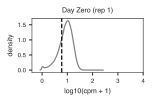

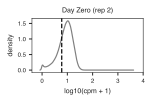

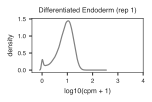

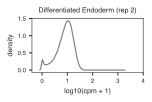

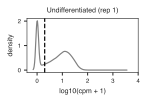

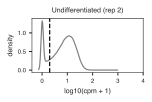

In [9]:
names = ["Day Zero (rep 1)", "Day Zero (rep 2)", "Differentiated Endoderm (rep 1)", "Differentiated Endoderm (rep 2)",
         "Undifferentiated (rep 1)", "Undifferentiated (rep 2)"]
count_threshs = [5, 5, np.nan, np.nan, 1, 1]

c = 1
for col, name, count_thresh in zip(data_cols, names, count_threshs):
    
    fig = plt.figure(figsize=(2, 1))
    ax = sns.distplot(np.log10(data[col]+1), hist=False, bins=15, kde=True, color="gray")
    ax.set_ylabel("density")
    ax.set_xlabel("log10(cpm + 1)")
    ax.set_title(name)
    ax.set_xlim((-0.4, 4))
    if count_thresh != np.nan:
        ax.axvline(x=np.log10(count_thresh+1), linestyle="dashed", color="black")
    plt.show()
    #fig.savefig("FigS5B_%s.pdf" % c, figure="dpi", bbox_inches="tight")
    plt.close()
    c += 1

## how do Day Zero l2fcs compare with Liu et al l2fcs (growth screen in iPSCs)

In [10]:
liu_sgrnas = pd.read_table("../../../misc/11__liu_data/sgRNA_metadata.txt")

In [11]:
liu_l2fcs = pd.read_table("../../../misc/11__liu_data/iPSC_sgRNA_data.txt")

In [12]:
l2fcs_dz_in_liu = l2fcs_dz.merge(liu_sgrnas[["Protospacer sequence", "sgRNA ID"]], left_on="sgRNA",
                                 right_on="Protospacer sequence")
print(len(l2fcs_dz_in_liu))

1117


In [13]:
l2fcs_dz_in_liu = l2fcs_dz_in_liu.merge(liu_l2fcs, left_on="sgRNA ID", right_on="sgRNA_ID")
print(len(l2fcs_dz_in_liu))

1117


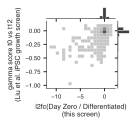

In [14]:
tmp = l2fcs_dz_in_liu[["sgRNA", "raw_l2fc", "l2fc", "gamma_t12_av", "gamma_t18_av"]].set_index("sgRNA")
g = sns.jointplot(data=tmp, x="l2fc", y="gamma_t12_av",
                  kind="hist", height=1.5, color="black", bins=20, marginal_kws={"bins": 20})
g.set_axis_labels("l2fc(Day Zero / Differentiated)\n(this screen)", "gamma score t0 vs t12\n(Liu et al. iPSC growth screen)")
g.savefig("FigS5F_1.pdf", dpi="figure", bbox_inches="tight")

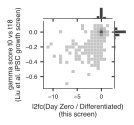

In [15]:
tmp = l2fcs_dz_in_liu[["sgRNA", "raw_l2fc", "l2fc", "gamma_t12_av", "gamma_t18_av"]].set_index("sgRNA")
g = sns.jointplot(data=tmp, x="l2fc", y="gamma_t18_av",
                  kind="hist", height=1.5, color="black", bins=20, marginal_kws={"bins": 20})
g.set_axis_labels("l2fc(Day Zero / Differentiated)\n(this screen)", "gamma score t0 vs t18\n(Liu et al. iPSC growth screen)")
g.savefig("FigS5F_2.pdf", dpi="figure", bbox_inches="tight")

In [16]:
l2fcs_dz_in_liu = l2fcs_dz_in_liu.merge(data[["sgRNA", "gene_name"]], on="sgRNA")
print(len(l2fcs_dz_in_liu))
l2fcs_dz_in_liu.sort_values(by="l2fc")[["l2fc", "gamma_t12_av", "gamma_t18_av", "gene_name", "sgRNA"]].head(10)

1117


l2fc  gamma_t12_av  gamma_t18_av      gene_name  \
247  -11.372963     -0.312814     -0.212796  RP11-967K21.1   
883  -10.625911     -0.276319     -0.173015        MIR302B   
118  -10.031741     -0.436649     -0.332671  RP11-296L22.8   
681   -8.764427     -0.507872     -0.387864    RP11-79P5.9   
128   -8.361881     -0.374890     -0.352306      OR2A1-AS1   
127   -8.361881     -0.374890     -0.352306      OR2A1-AS1   
490   -8.184885      0.033846     -0.003630   CTD-2270L9.4   
200   -8.148694     -0.479239     -0.340901       POT1-AS1   
1058  -8.127211     -0.436295     -0.350922  RP11-592B15.3   
997   -7.401492     -0.997782     -0.715972         SNHG20   

                     sgRNA  
247   GAGCGGAGAGCGCCCCACCG  
883   GAATCTTTGGGAACTAGTTC  
118   GAGAATGGCAGGCCCAGCAG  
681   GTGGCCTCTCCCAGAGGTAC  
128   GAGGAGGGCACCCACCTGGT  
127   GAGGAGGGCACCCACCTGGT  
490   GCCCAGCCGAGAGCAGGGGA  
200   GCGGTGGACCAGCTGCGTAA  
1058  GCGGCGCATTGAGGCAGGTG  
997   GGCCGATGGCGGCGGAACTG

## 3. join count data with l2fc data

In [17]:
data["scramble_id"] = data.apply(get_scramble_id, axis=1)
data["group_id"] = data.apply(get_group_id, axis=1)

In [18]:
data = data.merge(l2fcs, on="sgRNA")
data = data.merge(l2fcs_dz, on="sgRNA", suffixes=("_diff", "_dz"))
data.sample(5)

sgRNA   ctrl_status              gene_id  \
52020  CGTTTACTAAAGGTTTGTTG  experimental  ENSG00000274685.1_1   
80546  CCGGTAAATAAGGGCCCCGT  experimental  ENSG00000277978.1_1   
62089  GAAACAGCTTAGGGAGAAAG  experimental  ENSG00000180861.9_1   
27986  AGACCTATGCATCCTCATGT  experimental  ENSG00000251187.5_1   
7577   TGAGGGACCCTGCTAGATGC  experimental  ENSG00000232762.1_1   

            gene_name        transcript_id     transcript_name  \
52020  RP11-122K13.15  ENST00000621752.1_1  RP11-122K13.15-001   
80546   RP11-403P17.6  ENST00000612427.1_1   RP11-403P17.6-001   
62089       LINC01559  ENST00000532841.5_1       LINC01559-003   
27986     CTC-459M5.2  ENST00000506875.1_1     CTC-459M5.2-002   
7577     RP4-784A16.4  ENST00000446686.1_1    RP4-784A16.4-001   

      transcript_biotype_status tss_chr_hg38 tss_start_hg38 tss_strand_hg38  \
52020                intergenic        chr10      133374868               -   
80546          promoter_overlap        chr16       66566000               -   
62089                intergenic        chr12       13387166               -   
27986        transcript_overlap         chr5      112192047               +   
7577         transcript_overlap         chr1       53304536               +   

       ... stat_diff pvalue_diff padj_diff  baseMean_dz  raw_l2fc_dz  \
52020  ... -0.372068    0.709842  0.932849  2038.322539     0.284677   
80546  ...  0.356435    0.721515  0.936138  1292.461892    -0.500154   
62089  ...  0.604405    0.545575  0.871994   409.411094    -0.212302   
27986  ...  0.203733    0.838562  0.967073  1834.447964     0.086425   
7577   ... -1.303121    0.192534  0.595721  2937.632224     0.172947   

        l2fc_dz  l2fcSE_dz   stat_dz  pvalue_dz   padj_dz  
52020  0.330019   0.171287  1.661987   0.096515  0.429523  
80546 -0.633656   0.194185 -2.575651   0.010005  0.126848  
62089 -0.325150   0.237100 -0.895411   0.370567  0.731488  
27986  0.095354   0.164096  0.526670   0.598422  0.858208  
7577   0.204494   0.179385  0.964110   0.334991  0.705577  

[5 rows x 41 columns]

In [19]:
data[data["gene_name"] == "FOXA2"][["l2fc_diff", "l2fc_dz"]]

l2fc_diff   l2fc_dz
98504   3.857113 -1.373928
98505  -1.067257 -2.041965
98506  -2.897134 -2.758406
98507  -2.668777 -2.312957
98508  -3.446762 -2.269282
98509  -1.871501 -1.780823
98510  -1.573479 -1.939357
98511  -2.582382 -2.075912
98512   0.055291  0.104709
98513  -0.188802 -0.122571

In [20]:
# flip l2fcs (they are backwards coming out of DESeq2)
data["l2fc_diff"] = -data["l2fc_diff"]
data["l2fc_dz"] = -data["l2fc_dz"]

In [21]:
len(data)

111801

## 4. plot correlations across undifferentiated replicates for + control sgRNAs

In [22]:
data_ctrls = data[data["ctrl_status"] == "control"]

<Figure size 108x108 with 0 Axes>

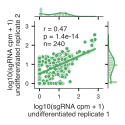

In [23]:
fig = plt.figure(figsize=(1.5, 1.5))

no_nan = data_ctrls[(~pd.isnull(data_ctrls["Neg_Rep1__cpm"])) & (~pd.isnull(data_ctrls["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))

g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", color=sns.color_palette()[2], kind="reg",
                   joint_kws={"scatter_kws": {"s": 15, "alpha": 1, "linewidths": 0.5, 
                              "edgecolors": "white"}},
                   marginal_kws={"bins": 20, "kde": True}, size=1.5, space=0.5)

g.ax_joint.set_xlim(-0.25, 3.25)
g.ax_joint.set_ylim(-0.25, 3.25)

g.ax_joint.set_xticks([0, 1, 2, 3])
g.ax_joint.set_yticks([0, 1, 2, 3])

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# annotate number of guides above thresh
r, p = stats.spearmanr(no_nan["Neg_Rep1__cpm"], no_nan["Neg_Rep2__cpm"])
g.ax_joint.text(0.2, 3, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 15), len(no_nan))), 
                ha="left", va="top", fontsize=fontsize)

plt.show()
plt.close()

In [24]:
data_ctrls = data[data["gene_name"].isin(["FOXA2", "SOX17"])]

<Figure size 108x108 with 0 Axes>

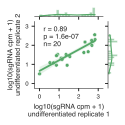

In [25]:
fig = plt.figure(figsize=(1.5, 1.5))

no_nan = data_ctrls[(~pd.isnull(data_ctrls["Neg_Rep1__cpm"])) & (~pd.isnull(data_ctrls["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))

g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", color=sns.color_palette()[2], kind="reg",
                   joint_kws={"scatter_kws": {"s": 15, "alpha": 1, "linewidths": 0.5, 
                              "edgecolors": "white"}},
                   marginal_kws={"bins": 20, "kde": True}, size=1.5, space=0.5)

g.ax_joint.set_xlim(-0.25, 3.25)
g.ax_joint.set_ylim(-0.25, 3.25)

g.ax_joint.set_xticks([0, 1, 2, 3])
g.ax_joint.set_yticks([0, 1, 2, 3])

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# annotate number of guides above thresh
r, p = stats.spearmanr(no_nan["Neg_Rep1__cpm"], no_nan["Neg_Rep2__cpm"])
g.ax_joint.text(0.2, 3, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 8), len(no_nan))), 
                ha="left", va="top", fontsize=fontsize)

plt.show()
plt.close()

r: 0.7991630920474704, p: 2.372891352638505e-05


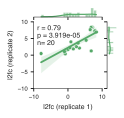

In [26]:
data_ctrls["l2fc_rep1"] = np.log2(data_ctrls["Neg_Rep1__cpm"]/data_ctrls["Pos_Rep1__cpm"])
data_ctrls["l2fc_rep2"] = np.log2(data_ctrls["Neg_Rep2__cpm"]/data_ctrls["Pos_Rep2__cpm"])

g = sns.jointplot(data=data_ctrls, x="l2fc_rep1", y="l2fc_rep2", 
                  color=sns.color_palette()[2], kind="reg",
                   joint_kws={"scatter_kws": {"s": 15, "alpha": 1, "linewidths": 0.5, 
                              "edgecolors": "white"}},
                   marginal_kws={"bins": 20, "kde": True}, size=1.5, space=0.5)

g.ax_joint.set_xlim(-10, 10)
g.ax_joint.set_ylim(-10, 10)

# g.ax_joint.set_xticks([-8, 1, 2, 3])
# g.ax_joint.set_yticks([0, 1, 2, 3])

g.set_axis_labels("l2fc (replicate 1)", 
                  "l2fc (replicate 2)")

# annotate number of guides above thresh
r, p = stats.pearsonr(data_ctrls["l2fc_rep1"], data_ctrls["l2fc_rep2"])
print("r: %s, p: %s" % (r, p))
r, p = stats.spearmanr(data_ctrls["l2fc_rep1"], data_ctrls["l2fc_rep2"])
g.ax_joint.text(-9, 9, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 8), len(data_ctrls))), 
                ha="left", va="top", fontsize=fontsize)

plt.show()
plt.close()

## 5. remove noisy sgRNAs -- based on scrambled guides day zero counts
set a day zero cpm cutoff in both replicates with the goal of removing most negative control outliers -- effective "signal to noise" cutoff.

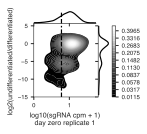

In [27]:
#fig = plt.figure(figsize=(1.5, 1.5))

no_nan = data[(~pd.isnull(data["DZ_Rep1__cpm"])) & (~pd.isnull(data["l2fc_diff"]))]
no_nan["DZ_Rep1__cpm"] = np.log10((no_nan["DZ_Rep1__cpm"]+1))
scram = no_nan[no_nan["ctrl_status"] == "scramble"]
g = sns.jointplot(data=scram, x="DZ_Rep1__cpm", y="l2fc_diff", cmap="Greys_r", kind="kde",
                  joint_kws={"shade": True, "shade_lowest": False, "n_levels": 30, "cbar": True},
                  marginal_kws={"color": "black"}, height=1.5)


## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

g.ax_joint.set_xlim((0, 1.75))
g.ax_joint.set_ylim((-15, 5))
g.ax_joint.axvline(x=np.log10(5+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(5+1), color="black", linestyle="dashed")

g.set_axis_labels("log10(sgRNA cpm + 1)\nday zero replicate 1", 
                  "log2(undifferentiated/differentiated)")

plt.show()
g.savefig("FigS5B_1.pdf", dpi="figure", bbox_inches="tight")
plt.close()

<Figure size 108x108 with 0 Axes>

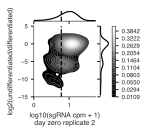

In [28]:
fig = plt.figure(figsize=(1.5, 1.5))

no_nan = data[(~pd.isnull(data["DZ_Rep2__cpm"])) & (~pd.isnull(data["l2fc_diff"]))]
no_nan["DZ_Rep2__cpm"] = np.log10((no_nan["DZ_Rep2__cpm"]+1))
scram = no_nan[no_nan["ctrl_status"] == "scramble"]
g = sns.jointplot(data=scram, x="DZ_Rep2__cpm", y="l2fc_diff", cmap="Greys_r", kind="kde", height=1.5,
                  joint_kws={"shade": True, "shade_lowest": False, "n_levels": 30, "cbar": True},
                  marginal_kws={"color": "black"},
                  size=1.5, space=0.5)

## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

g.ax_joint.set_xlim((0, 1.75))
g.ax_joint.set_ylim((-15, 5))
g.ax_joint.axvline(x=np.log10(5+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(5+1), color="black", linestyle="dashed")

g.set_axis_labels("log10(sgRNA cpm + 1)\nday zero replicate 2", 
                  "log2(undifferentiated/differentiated)")

plt.show()
g.savefig("FigS5B_2.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [29]:
data_filt = data[(data["DZ_Rep1__cpm"] >= 5) & (data["DZ_Rep2__cpm"] >= 5)]
len(data_filt)

76091

## 6. remove noisy sgRNAs -- that are only captured in one undifferentiated replicate

we can see from the histograms above that many sgRNAs are not captured at all in a given undifferentiated replicate. this will add a ton of noise to our analysis -- so we will filter to only capture sgRNAs that are in both replicates, and a cpm of 1 perfectly separates the bimodal histogram

<Figure size 144x144 with 0 Axes>

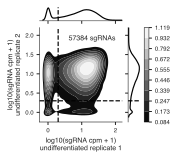

In [30]:
fig = plt.figure(figsize=(2, 2))

no_nan = data_filt[(~pd.isnull(data_filt["Neg_Rep1__cpm"])) & (~pd.isnull(data["Neg_Rep2__cpm"]))]
no_nan["Neg_Rep1__cpm"] = np.log10((no_nan["Neg_Rep1__cpm"]+1))
no_nan["Neg_Rep2__cpm"] = np.log10((no_nan["Neg_Rep2__cpm"]+1))
g = sns.jointplot(data=no_nan, x="Neg_Rep1__cpm", y="Neg_Rep2__cpm", cmap="Greys_r", kind="kde",
                  joint_kws={"shade": True, "shade_lowest": False, "n_levles": 15, "cbar": True},
                  marginal_kws={"color": "black"},
                  size=2, space=0.5)

## move color bar
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, 2, pos_joint_ax.height])


g.ax_joint.axhline(y=np.log10(1+1), color="black", linestyle="dashed")
g.ax_joint.axvline(x=np.log10(1+1), color="black", linestyle="dashed")
g.ax_marg_y.axhline(y=np.log10(1+1), color="black", linestyle="dashed")
g.ax_marg_x.axvline(x=np.log10(1+1), color="black", linestyle="dashed")
g.ax_joint.set_xlim(-0.25, 2.2)
g.ax_joint.set_ylim(-0.25, 2.2)

g.set_axis_labels("log10(sgRNA cpm + 1)\nundifferentiated replicate 1", 
                  "log10(sgRNA cpm + 1)\nundifferentiated replicate 2")

# g.ax_joint.set_xticks([0, 2, 4, 6])
# g.ax_joint.set_yticks([0, 2, 4, 6])

# annotate number of guides above thresh
n = len(data_filt[(data_filt["Neg_Rep1__cpm"] >= 1) & (data_filt["Neg_Rep2__cpm"] >= 1)])
g.ax_joint.text(2, 2, "%s sgRNAs" % (n), ha="right", va="top", fontsize=fontsize)

plt.show()
g.savefig("Fig3C.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [31]:
data_filt = data_filt[(data_filt["Neg_Rep1__cpm"] >= 1) & (data_filt["Neg_Rep2__cpm"] >= 1)]
len(data_filt)

57384

## 6. plot coverage of guides after filtering

In [32]:
data_filt_cnts = data_filt.groupby(["group_id", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_tot_cnts = data.groupby(["group_id", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_cnts = data_tot_cnts.merge(data_filt_cnts, on=["group_id", "ctrl_status"], how="left", 
                                suffixes=("_tot", "_filt"))
data_cnts.head()

group_id   ctrl_status  sgRNA_tot  sgRNA_filt
0  NC_000001.11:+:100894913  experimental         10         4.0
1  NC_000001.11:+:100995473  experimental         10         8.0
2  NC_000001.11:+:101025906  experimental          8         3.0
3  NC_000001.11:+:101072856  experimental          9         2.0
4  NC_000001.11:+:101081966  experimental         10         7.0

In [33]:
data_cnts.fillna(0, inplace=True)
data_cnts.sample(5)

group_id   ctrl_status  sgRNA_tot  sgRNA_filt
38    NC_000001.11:+:114032377  experimental         10         7.0
2607  NC_000004.12:-:138312686  experimental         10         5.0
9403   NC_000019.10:+:36014508  experimental         10         7.0
4986  NC_000009.12:-:136937987  experimental         10         6.0
8402   NC_000017.11:+:32496137  experimental         10         5.0

In [34]:
data_cnts.ctrl_status.value_counts()

experimental    10556
scramble          500
mRNA              272
control            24
Name: ctrl_status, dtype: int64

In [35]:
data_cnts_ns = data_cnts[data_cnts["ctrl_status"] != "scramble"]

In [36]:
n_ov3 = len(data_cnts_ns[data_cnts_ns["sgRNA_filt"] >= 3])
n_tot = len(data_cnts_ns)
p_ov3 = n_ov3/n_tot

print(n_ov3)
print(n_tot)
print(p_ov3)

9771
10852
0.9003870254330999


In [37]:
guide_cov = pd.DataFrame(data_cnts_ns["sgRNA_filt"].value_counts()).reset_index().sort_values(by="index")
guide_cov

index  sgRNA_filt
9     0.0         128
7     1.0         326
6     2.0         627
4     3.0        1241
2     4.0        1792
0     5.0        2146
1     6.0        2037
3     7.0        1504
5     8.0         754
8     9.0         259
10   10.0          38

Text(10.3, 2150, '9771 TSSs\n(90%)')

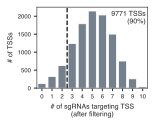

In [38]:
fig = plt.figure(figsize=(2, 1.5))

ax = sns.barplot(data=guide_cov, x="index", y="sgRNA_filt", color="slategray")
ax.set_xlabel("# of sgRNAs targeting TSS\n(after filtering)")
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_ylabel("# of TSSs")
ax.set_xlim(-0.5, 10.5)

ax.axvline(x=2.5, linestyle="dashed", color="black")
ax.text(10.3, 2150, "%s TSSs\n(%s%%)" % (n_ov3, round(p_ov3*100)), ha="right", va="top")

## 7. remove any targeted TSSs with < 3 sgRNAs that meet above filters
but keep all scrambled negative controls

In [39]:
## get group_ids that have >= 3 guides
good_grps = data_cnts_ns[data_cnts_ns["sgRNA_filt"] >= 3]["group_id"]
len(good_grps)

9771

In [40]:
# limit targeted tsss to those that have >= 3 guides meeting filters
data_filt_ns = data_filt[data_filt["ctrl_status"] != "scramble"]
data_filt_s = data_filt[data_filt["ctrl_status"] == "scramble"]
data_filt_ns = data_filt_ns[data_filt_ns["group_id"].isin(good_grps)]
data_filt = data_filt_ns.append(data_filt_s)
len(data_filt)

55804

## 8. check control and biotype counts in this filtered set

In [41]:
data_filt.ctrl_status.value_counts()

experimental    51493
scramble         2690
mRNA             1483
control           138
Name: ctrl_status, dtype: int64

In [42]:
data_filt.drop_duplicates(subset="group_id").ctrl_status.value_counts()

experimental    9493
scramble         492
mRNA             255
control           23
Name: ctrl_status, dtype: int64

In [43]:
tmp = data_filt[data_filt["ctrl_status"] == "experimental"].drop_duplicates(subset="group_id")
tmp.transcript_biotype_status.value_counts()

transcript_overlap    3587
intergenic            2893
promoter_overlap      2753
gene_nearby            180
multi-targeting         80
Name: transcript_biotype_status, dtype: int64

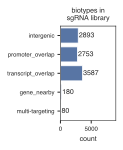

In [44]:
fig = plt.figure(figsize=(1, 1.75))

order = ["intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby", "multi-targeting"]
ax = sns.countplot(data=tmp, y="transcript_biotype_status", order=order, color=sns.color_palette()[0])

for p in ax.patches:
    w = p.get_width()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(w + 100, y + h/2, int(w), ha="left", va="center", fontsize=fontsize) 
    
plt.xlim((0,9000))
plt.ylabel("")
plt.title("biotypes in\nsgRNA library")
fig.savefig("FigS5D_2.pdf", dpi="figure", bbox_inches="tight")

## 8. check distribution of l2fcs for control guides vs. negative control guides

for CRISPhieRmix to work properly, it assumes that the majority of targeting guides do not work or are inefficient at knockdown and will act like negative controls. make sure this is true -- dists overlap

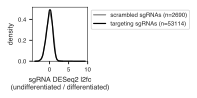

In [45]:
fig = plt.figure(figsize=(1, 1))

scram = data_filt[data_filt["ctrl_status"] == "scramble"]
notscram = data_filt[data_filt["ctrl_status"] != "scramble"]

ax = sns.distplot(scram["l2fc_diff"], hist=False, color="gray", label="scrambled sgRNAs (n=%s)" % len(scram))
sns.distplot(notscram["l2fc_diff"], hist=False, color="black", label="targeting sgRNAs (n=%s)" % len(notscram))
ax.set_xlabel("sgRNA DESeq2 l2fc\n(undifferentiated / differentiated)")
ax.set_ylabel("density")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
fig.savefig("FigS5G.pdf", dpi="figure", bbox_inches="tight")

negative control guides look identical to targeting guides -- this is good for CRISPhieRmix

## 9. plot enrichment scores of neg ctrl sgRNAs vs pos ctrl sgRNAs

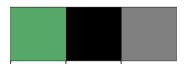

In [46]:
pal = {"control": sns.color_palette()[2], "experimental": "black", "scramble": "gray"}
sns.palplot(pal.values())

0.0001741114875821667


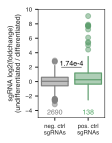

In [47]:
fig = plt.figure(figsize=(1.2, 2))

ax = sns.boxplot(data=data_filt, x="ctrl_status", y="l2fc_diff", order=["scramble", "control"],
                 palette=pal, flierprops=dict(marker='o', markersize=5))
mimic_r_boxplot(ax)
ax.set_xticklabels(["neg. ctrl\nsgRNAs", "pos. ctrl\nsgRNAs"], rotation=0, ha="center",
                   va="top")
ax.set_xlabel("")
ax.set_ylabel("sgRNA log2(foldchange)\n(undifferentiated / differentiated)")
ax.set_ylim(-5, 10)

# calc p-vals b/w dists
vals1 = np.asarray(data_filt[data_filt["ctrl_status"] == "scramble"]["l2fc_diff"])
vals2 = np.asarray(data_filt[data_filt["ctrl_status"] == "control"]["l2fc_diff"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

u, pval = stats.mannwhitneyu(vals1, vals2, alternative="less", use_continuity=False)
print(pval)
annotate_pval(ax, 0.2, 0.8, 2, 0, 2, pval, fontsize)

for i, x in enumerate(["scramble", "control"]):
    n = len(data_filt[data_filt["ctrl_status"] == x])
    ax.text(i, -4.75, n, color=pal[x], va="bottom", ha="center")

fig.savefig("Fig3E.pdf", bbox_inches="tight", dpi="figure")

### example plot of guide distributions

In [48]:
scram = data_filt[data_filt["ctrl_status"] == "scramble"]

7


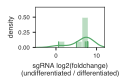

In [49]:
sox17 = data_filt[data_filt["gene_name"] == "SOX17"]
print(len(sox17))

fig = plt.figure(figsize=(1.25, 0.75))
ax = sns.distplot(sox17["l2fc_diff"], color=pal["control"], rug=True, hist=True, rug_kws={"height": 0.15})
ax.set_ylabel("density")
ax.set_xlabel("sgRNA log2(foldchange)\n(undifferentiated / differentiated)")
ax.set_xlim((-5, 12))
fig.savefig("FigS5H.pdf", bbox_inches="tight", dpi="figure")

## 10. write file needed for CRISPhieRmix

In [50]:
data_filt = data_filt.merge(data_cnts[["group_id", "sgRNA_filt"]], on="group_id")
len(data_filt)

55804

In [51]:
data_filt["group_id_rd"] = data_filt["transcript_name"] + ";;;" + data_filt["group_id"] + ";;;" + data_filt["ctrl_status"] + ";;;" + data_filt["transcript_biotype_status"] + ";;;" + data_filt["sgRNA_filt"].astype(int).astype(str)

In [52]:
f = "../../../data/02__screen/02__enrichment_data/data_filt.with_batch.tmp"
data_filt = data_filt[~pd.isnull(data_filt["l2fc_diff"])]
print(len(data_filt))
data_filt.to_csv(f, sep="\t", index=False)

55804


In [53]:
data_filt_grp = data_filt.groupby(["group_id_rd", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_filt_grp.ctrl_status.value_counts()

experimental    9493
mRNA             255
control           23
Name: ctrl_status, dtype: int64

In [54]:
data_filt.ctrl_status.value_counts()

experimental    51493
scramble         2690
mRNA             1483
control           138
Name: ctrl_status, dtype: int64

In [55]:
## also write less-filtered version for dz drop outs
data_filt_dz = data[(data["DZ_Rep1__cpm"] >= 5) & (data["DZ_Rep2__cpm"] >= 5)]
len(data_filt_dz)

76091

In [56]:
data_filt_dz_cnts = data_filt_dz.groupby(["group_id", "ctrl_status"])["sgRNA"].agg("count").reset_index()
data_dz_cnts = data_tot_cnts.merge(data_filt_dz_cnts, on=["group_id", "ctrl_status"], how="left", 
                                   suffixes=("_tot", "_filt"))
data_dz_cnts.head()

group_id   ctrl_status  sgRNA_tot  sgRNA_filt
0  NC_000001.11:+:100894913  experimental         10         5.0
1  NC_000001.11:+:100995473  experimental         10         9.0
2  NC_000001.11:+:101025906  experimental          8         5.0
3  NC_000001.11:+:101072856  experimental          9         4.0
4  NC_000001.11:+:101081966  experimental         10         8.0

In [57]:
data_filt_dz = data_filt_dz.merge(data_dz_cnts[["group_id", "sgRNA_filt"]], on="group_id")
len(data_filt_dz)

76091

In [58]:
data_filt_dz = data_filt_dz[(data_filt_dz["sgRNA_filt"] >= 3) | (data_filt_dz["ctrl_status"] == "scramble")]
print(len(data_filt_dz))
print(len(data_filt_dz.group_id.unique()))

75599
10978


In [59]:
data_filt_dz["group_id_rd"] = data_filt_dz["transcript_name"] + ";;;" + data_filt_dz["group_id"] + ";;;" + data_filt_dz["ctrl_status"] + ";;;" + data_filt_dz["transcript_biotype_status"] + ";;;" + data_filt_dz["sgRNA_filt"].astype(int).astype(str)

In [60]:
f = "../../../data/02__screen/02__enrichment_data/data_filt_dz.with_batch.tmp"
data_filt_dz = data_filt_dz[~pd.isnull(data_filt_dz["l2fc_dz"])]
print(len(data_filt_dz))
data_filt_dz.to_csv(f, sep="\t", index=False)

75599


## 11. write supplementary file (contains all sgRNA data, not just filtered ones)

In [61]:
data.columns

Index(['sgRNA', 'ctrl_status', 'gene_id', 'gene_name', 'transcript_id',
       'transcript_name', 'transcript_biotype_status', 'tss_chr_hg38',
       'tss_start_hg38', 'tss_strand_hg38', 'tss_type', 'tss_id_hg38',
       'sgRNA_id', 'DZ_Rep1__counts', 'DZ_Rep2__counts', 'Pos_Rep1__counts',
       'Pos_Rep2__counts', 'Neg_Rep1__counts', 'Neg_Rep2__counts',
       'DZ_Rep1__cpm', 'DZ_Rep2__cpm', 'Pos_Rep1__cpm', 'Pos_Rep2__cpm',
       'Neg_Rep1__cpm', 'Neg_Rep2__cpm', 'scramble_id', 'group_id',
       'baseMean_diff', 'raw_l2fc_diff', 'l2fc_diff', 'l2fcSE_diff',
       'stat_diff', 'pvalue_diff', 'padj_diff', 'baseMean_dz', 'raw_l2fc_dz',
       'l2fc_dz', 'l2fcSE_dz', 'stat_dz', 'pvalue_dz', 'padj_dz'],
      dtype='object')

In [62]:
def filt_status(row):
    if row.DZ_Rep1__cpm >= 5 and row.DZ_Rep2__cpm >= 5:
        if row.Neg_Rep1__cpm >= 1 and row.Neg_Rep2__cpm >= 1:
            if row.ctrl_status != "scramble":
                if row.group_id in list(good_grps):
                    return "filter met"
                else:
                    return "filter not met"
            else:
                return "filter met"
        else:
            return "filter not met"
    else:
        return "filter not met"
    
data["filt_status"] = data.apply(filt_status, axis=1)

In [63]:
supp = data[["sgRNA", "ctrl_status", "gene_name", "gene_id", "transcript_name", "transcript_id", "group_id", 
             "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
             "DZ_Rep1__counts", "DZ_Rep2__counts", "Neg_Rep1__counts", "Neg_Rep2__counts", "Pos_Rep1__counts", 
             "Pos_Rep2__counts", "DZ_Rep1__cpm", "DZ_Rep2__cpm", "Neg_Rep1__cpm", "Neg_Rep2__cpm", "Pos_Rep1__cpm",
             "Pos_Rep2__cpm", "filt_status", "l2fc_diff", "l2fcSE_diff", "l2fc_dz", "l2fcSE_dz"]]
supp.columns = ["sgRNA", "control_status", "gene_name", "gene_id", "transcript_name", "transcript_id", "tss_id",
                "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
                "DayZero_Rep1__counts", "DayZero_Rep2__counts", "Undiff_Rep1__counts", "Undiff_Rep2__counts", 
                "Diff_Rep1__counts", "Diff_Rep2__counts", "DayZero_Rep1__cpm", "DayZero_Rep2__cpm", 
                "Undiff_Rep1__cpm", "Undiff_Rep2__cpm", "Diff_Rep1__cpm", "Diff_Rep2__cpm",
                "sgRNA_status", "sgRNA_l2fc_diff", "sgRNA_l2fcSE_diff", "sgRNA_l2fc_dz", "sgRNA_l2fcSE_dz"]
supp.sgRNA_status.value_counts()

filter not met    55997
filter met        55804
Name: sgRNA_status, dtype: int64

In [64]:
supp.to_csv("../../../data/02__screen/02__enrichment_data/SuppTable_S2.sgRNA_results.txt", sep="\t", index=False)

In [65]:
supp[~pd.isnull(supp["sgRNA_l2fc_diff"])][["sgRNA", "gene_name", "sgRNA_l2fc_dz", "sgRNA_l2fc_diff"]].sort_values(by="sgRNA_l2fc_dz").tail(20)

sgRNA      gene_name  sgRNA_l2fc_dz  sgRNA_l2fc_diff
89322   CGGGCAGAGGCGGCGAGAGG        SLC16A3       9.456852        -1.234373
65428   CTGGAAGATGTTAGAGAAAT          NANOG       9.599656         6.518463
68890   CCAGGAGGTAGGGGGAGAGA   RP11-168L7.1       9.761814        -1.137195
55579   CACCCTACGCAAAATAGCGG   RP11-770J1.5       9.818115        -1.807760
99161   AACCGCGCGGAGGAGGCTGA         SNHG11       9.864260        -1.137195
94092   GCCGTGGTGGGGCTGCGGTG         SPPL2B       9.913304         4.943153
33836   CAGGCCAAGGGAGTAGAAGG    RP11-69I8.2       9.918110        26.152401
49083   GAGAATGGCAGGCCCAGCAG  RP11-296L22.8      10.031741        25.365735
86654   CAAGGGGTGAAGGGAAAGGA       HOXB-AS3      10.052688        -1.137195
55581   GCCGGGGCGGGATGGCCTGC   RP11-770J1.5      10.328265        25.355020
57829   GTGAGCTCTCTCTAACCCTG  RP11-804A23.2      10.428401         5.075893
23664   GAATCTTTGGGAACTAGTTC        MIR302B      10.625911         1.582006
68048   TGGCCGGTCATCATCCACAC   RNASEH2B-AS1      10.855252        24.502028
21479   GCAGTTAGGGGAGCAGCTCT          EOMES      10.977285         8.390779
2380    GTCGTGTCGCCCCCAAGGCA    RP11-98G7.1            NaN         6.871736
24934   ATACCTCAAGATTATCAGAT     AC097467.2            NaN         1.582006
48640   TGCGAGGCCACAGGGAAATC        FAM157B            NaN         2.532927
80261   AGAGCCGACTCTAACCAAGT  RP11-343H19.1            NaN         5.778147
84719   GGAGCGGAGCGCAGGAAGGG  RP11-466A19.6            NaN         5.563670
109146  GCTGTGGGCAGTGGCGTGCG       scramble            NaN         2.147592

In [66]:
supp[supp["gene_name"] == "scramble"][["sgRNA", "gene_name", "sgRNA_l2fc_dz", "sgRNA_l2fc_diff"]]

sgRNA gene_name  sgRNA_l2fc_dz  sgRNA_l2fc_diff
106801  AAAAATACTAGAGTATCGCC  scramble       0.631537        -2.725787
106802  AAACAGCCGCGAGAACGTGA  scramble       0.021630         2.018626
106803  AAACAGGATACTACTTAGGA  scramble       0.738628        -3.930209
106804  AAACTATTGATACATCGGAG  scramble       0.057951        -6.515933
106805  AAACTCAACTACGAAAACGG  scramble      -0.452112         0.074297
...                      ...       ...            ...              ...
111796  TTTAGCTTAGGCCTTAATGG  scramble      -0.097518         1.127659
111797  TTTAGTGAGGCGCGGACCGT  scramble      -0.462994        -0.755000
111798  TTTATAGTAAAAGGTCGTTT  scramble      -0.582206        -6.288623
111799  TTTCGAGAGAATTGGCCGGG  scramble       0.546246         0.406786
111800  TTTGGTTCCCACACGTTTGC  scramble      -0.037462        -0.438253

[5000 rows x 4 columns]